# Library / Packages

In [1]:
# basic library
import os
import pandas as pd
import numpy as np
import sys


# complex math
from scipy import stats
from scipy.stats import gaussian_kde

# data preparation
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 

# data blueprint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from sklearn.neighbors import NearestNeighbors

# data modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# data cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# data metrics
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix

# data tuning   
from itertools import product
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.calibration import CalibratedClassifierCV

# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# pickle and .env
from dotenv import dotenv_values
import pickle

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Fungsi untuk konversi tipe data
def convert_object_columns_to_numeric(df):
    for col in df.select_dtypes(include = ['object']).columns:  
        try:
            # Cek apakah semua nilai bisa dikonversi ke float
            df[col] = pd.to_numeric(df[col], errors='raise')
            
            # Jika bisa, ubah ke int jika semua nilai adalah bilangan bulat
            if all(df[col] % 1 == 0):  # Cek apakah semua nilai adalah bilangan bulat
                df[col] = df[col].astype(int)

        except ValueError:
            pass  # Jika ada nilai non-angka, biarkan tetap object
        
    return df

# Data Source

In [5]:
# parameter
share = {**dotenv_values('../.env.shared')} 

# read pickle
with open(share['CLEAN_DATA'], 'rb') as f:
    loaded_data = pickle.load(f)

cc_df = pd.DataFrame(loaded_data)
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283712 entries, 0 to 283711
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                283712 non-null  int64         
 1   datetime                   283712 non-null  datetime64[ns]
 2   long                       283712 non-null  float64       
 3   lat                        283712 non-null  float64       
 4   zipcode                    283712 non-null  int64         
 5   state                      283712 non-null  object        
 6   city                       283712 non-null  object        
 7   year                       283712 non-null  int32         
 8   quarter                    283712 non-null  object        
 9   month                      283712 non-null  object        
 10  season                     283712 non-null  object        
 11  week_cat                   283712 non-null  object  

In [6]:
cc_df.head()

,credit_card,datetime,long,lat,zipcode,state,city,year,quarter,month,season,week_cat,day,credit_card_limit,limit_cat,transaction_dollar_amount,transaction_count,time_diff_per_seconds,prev_long,prev_lat,distance,geo_cat,fraud_status,cc_id,trx_id
0,9484591448272784,2015-07-31 09:39:48,-90.045639,29.889039,70112,la,new orleans,2015,2015Q3,july,summer,weekday,friday,4000,very_low,17.99,1.0,-7642455.0,-90.151504,29.945202,11.969568,normal,not_fraud,ac1e34e60d6ad33e82c597a0f269fe2b5e83428562d3aa...,0bc4a969dccbe3b475e9e374e53e9e3fce6dbf1e7da2fe...
1,7053196367895112,2015-07-31 11:03:48,-74.027561,40.689615,10001,ny,new york,2015,2015Q3,july,summer,weekday,friday,18000,low,12.09,1.0,-2527299.0,-73.927029,40.806511,15.511210,normal,not_fraud,1c266eb56e8271b57de874865469dc04abb5110ef52821...,03ba63876abb11634b3f875ddad559ee63940573628739...
2,9528285469413252,2015-07-31 11:10:14,-72.139485,43.108100,3280,nh,washington,2015,2015Q3,july,summer,weekday,friday,40000,very_high,78.21,1.0,-6508550.0,-72.064113,43.172281,9.404226,normal,not_fraud,6733096fda61cddbcb8e2cd74676332d87594d058be167...,b86ab6aa560ba291acec2dd27b90f810165ff9023aab47...
3,1845720274833905,2015-07-31 11:28:55,-89.002148,40.804323,61738,il,el paso,2015,2015Q3,july,summer,weekday,friday,20000,medium,74.41,1.0,-2534699.0,-88.974492,40.720877,9.556419,normal,not_fraud,c046d480aab2d35f98751ac74f030eff8d3c74005ac01c...,7e58fe9a9c6d89388acbd39be811095b6f13614fb16b93...
4,7850942767136368,2015-07-31 11:38:51,-72.025675,43.210753,3280,nh,washington,2015,2015Q3,july,summer,weekday,friday,4000,very_low,54.89,1.0,-1785659.0,-72.125392,43.219223,8.157130,normal,not_fraud,c59721adc2284ba7805c637ce4b1d25046d366d12833c0...,595746461886416a18a9ab75bde2742d402301a27b8f28...


# Data Modeling

### Check Irrelevant Data

#### Threshold Methode 

In [7]:
from sklearn.feature_selection import VarianceThreshold

# Drop kolom non-numerik
df_numeric = cc_df.select_dtypes(include = ['number'])
print(f'numeric columns: {df_numeric.columns}\n')

# Inisialisasi VarianceThreshold (misalnya, ambang batas 0.01)
selector = VarianceThreshold(threshold = 0.01)
df_var_selected = selector.fit_transform(df_numeric)

# Fitur yang dipertahankan
selected_features = df_numeric.columns[selector.get_support()]
print("Fitur yang dipertahankan:", selected_features)

numeric columns: Index(['credit_card', 'long', 'lat', 'zipcode', 'year', 'credit_card_limit',
       'transaction_dollar_amount', 'transaction_count',
       'time_diff_per_seconds', 'prev_long', 'prev_lat', 'distance'],
      dtype='object')

Fitur yang dipertahankan: Index(['credit_card', 'long', 'lat', 'zipcode', 'credit_card_limit',
       'transaction_dollar_amount', 'time_diff_per_seconds', 'prev_long',
       'prev_lat', 'distance'],
      dtype='object')


In [8]:
# Seleceted numeric columns
filter_numeric = ['long', 'lat', 'prev_long', 'prev_lat', 'credit_card', 'zipcode', 'credit_card_limit']
selected_numeric = selected_features.drop(filter_numeric)

#
print("Numeric column untuk modeling:", selected_numeric)

Numeric column untuk modeling: Index(['transaction_dollar_amount', 'time_diff_per_seconds', 'distance'], dtype='object')


#### Relevant Column

In [9]:
# Check Column Category
check_cat = cc_df.select_dtypes(include = ['object'])

for i in check_cat.columns:
    unique_values = check_cat[i].unique()  # Mendapatkan nilai unik
    unique_count = check_cat[i].nunique()  # Menghitung jumlah unik
    print(f'{i.upper()} \t: {unique_values}')
    print(f'{"-" * 50} \n')

STATE 	: ['la' 'ny' 'nh' 'il' 'pa' 'nj' 'mo' 'md' 'ca' 'tx' 'me' 'vt' 'al' 'wv'
 'pr' 'wa' 'nc' 'ga' 'ma' 'ok' 'mi' 'ut' 'fl' 'hi' 'ia' 'nm' 'oh' 'az'
 'va' 'in' 'ri' 'id' 'co' 'ct' 'ks']
-------------------------------------------------- 

CITY 	: ['new orleans' 'new york' 'washington' 'el paso' 'dallas' 'houston'
 'birmingham' 'kansas city' 'austin' 'pasadena' 'los angeles' 'fort worth'
 'jackson' 'pittsburgh' 'portland' 'albany' 'charlotte' 'huntsville'
 'madison' 'orlando' 'san antonio' 'seattle' 'minneapolis' 'sacramento'
 'san francisco' 'memphis' 'dayton' 'denver' 'milwaukee' 'omaha' 'trenton'
 'springfield' 'oklahoma city' 'charleston' 'miami' 'long beach' 'quitman'
 'saint louis' 'friendship' 'chicago' 'salt lake city' 'richmond'
 'pensacola' 'san diego' 'atlanta' 'honolulu' 'greensboro' 'newark'
 'rochester' 'lafayette' 'columbus' 'staten island' 'des moines'
 'las vegas' 'chester' 'cincinnati' 'hillsboro' 'tucson' 'buffalo'
 'arlington' 'shreveport' 'philadelphia' 'tulsa' 'c

In [10]:
for i in check_cat.columns:
    unique_count = check_cat[i].nunique()  # Menghitung jumlah nilai unik
    
    if unique_count > 10:  # Filter hanya kolom dengan nilai unik lebih dari 10
        unique_values = check_cat[i].unique()  # Mendapatkan nilai unik
        # print(f'{i.upper()} \t: {unique_values}')
        print(f'Jumlah unik {i.upper()} \t: {unique_count}')
        print(f'{"-" * 50} \n')


Jumlah unik STATE 	: 35
-------------------------------------------------- 

Jumlah unik CITY 	: 123
-------------------------------------------------- 

Jumlah unik CC_ID 	: 283712
-------------------------------------------------- 

Jumlah unik TRX_ID 	: 283712
-------------------------------------------------- 



In [11]:
# Drop kolom numerik
df_obj = cc_df.select_dtypes(include = ['object'])
print(f'objetc columns: {df_obj.columns}\n')

objetc columns: Index(['state', 'city', 'quarter', 'month', 'season', 'week_cat', 'day',
       'limit_cat', 'geo_cat', 'fraud_status', 'cc_id', 'trx_id'],
      dtype='object')



In [12]:
# selected object columns
filter_obj = ['city', 'limit_cat', 'fraud_status', 'geo_cat']
selected_object = df_obj[filter_obj].columns

#
print("Object column untuk modeling:", selected_object)

Object column untuk modeling: Index(['city', 'limit_cat', 'fraud_status', 'geo_cat'], dtype='object')


In [13]:
# 
trans_col = selected_numeric.append(selected_object)

# 
trans_col = cc_df[trans_col]
trans_col.head()

,transaction_dollar_amount,time_diff_per_seconds,distance,city,limit_cat,fraud_status,geo_cat
0,17.99,-7642455.0,11.969568,new orleans,very_low,not_fraud,normal
1,12.09,-2527299.0,15.511210,new york,low,not_fraud,normal
2,78.21,-6508550.0,9.404226,washington,very_high,not_fraud,normal
3,74.41,-2534699.0,9.556419,el paso,medium,not_fraud,normal
4,54.89,-1785659.0,8.157130,washington,very_low,not_fraud,normal


In [14]:
# 
print("Proporsi Target Data:")
print(f"Total Rows: {len(trans_col)}")
print(trans_col["fraud_status"].value_counts(normalize=True) * 100, '\n')
print(trans_col["fraud_status"].value_counts())

Proporsi Target Data:
Total Rows: 283712
fraud_status
not_fraud    98.246109
fraud         1.753891
Name: proportion, dtype: float64 

fraud_status
not_fraud    278736
fraud          4976
Name: count, dtype: int64


### Check Noise Data

#### Boxplot

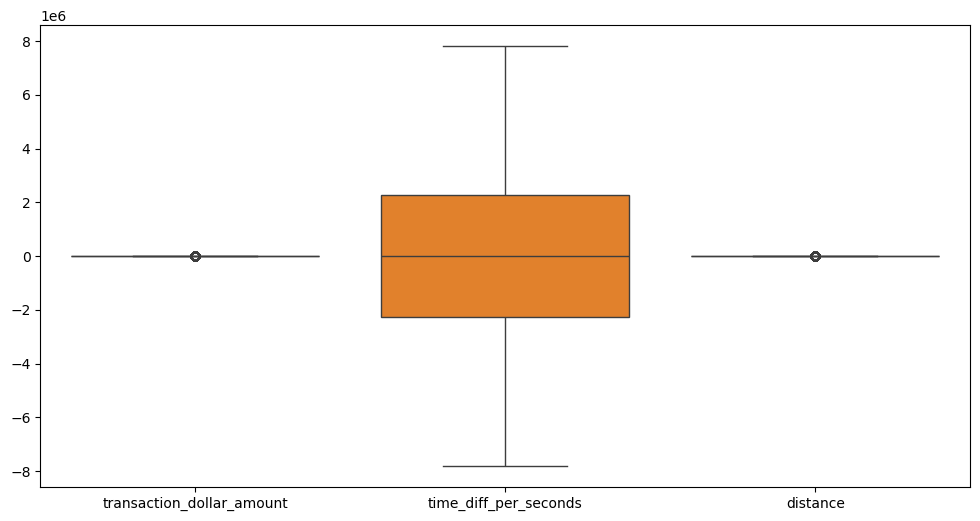

In [15]:
plt.figure(figsize = (12,6))
sns.boxplot(data = trans_col.select_dtypes(include = ["number"])) 
plt.show()

#### Z-Score

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Kolom numerik yang ingin dicek outliernya
num_cols = ["transaction_dollar_amount", "distance"]

# Hitung z-score
z_scores = np.abs(zscore(trans_col[num_cols]))

# Tandai data yang memiliki outlier
outlier_mask = (z_scores > 3).any(axis=1)

# Jumlah outlier sebelum Winsorization
num_outliers_before = outlier_mask.sum()
print(f"Jumlah outlier yang terdeteksi: {num_outliers_before} \n")

Jumlah outlier yang terdeteksi: 12457 



#### Winsorization

In [17]:
clip_percent = 3.2

# Winsorization hanya untuk data "not_fraud"
for col in num_cols:
    lower = np.percentile(trans_col[trans_col["fraud_status"] == "not_fraud"][col], clip_percent)
    upper = np.percentile(trans_col[trans_col["fraud_status"] == "not_fraud"][col], 100 - clip_percent)

    trans_col.loc[trans_col["fraud_status"] == "not_fraud", col] = np.clip(
        trans_col.loc[trans_col["fraud_status"] == "not_fraud", col], lower, upper
    )

# Cek apakah outlier masih ada setelah Winsorization
z_scores_after = np.abs(zscore(trans_col[num_cols]))
outlier_mask_after = (z_scores_after > 3).any(axis=1)

num_outliers_after = outlier_mask_after.sum()
print(f"Jumlah outlier setelah Winsorization: {num_outliers_after} \n")

Jumlah outlier setelah Winsorization: 4935 



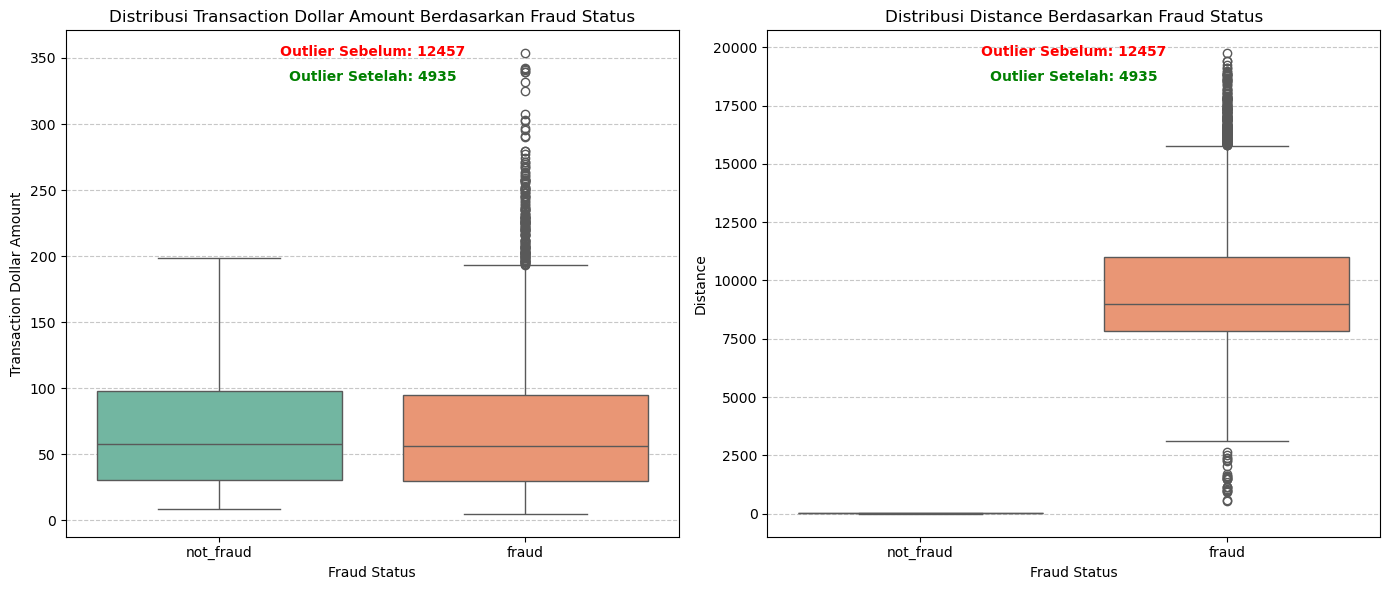

In [18]:
# Visualisasi dengan subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot untuk transaction_dollar_amount
sns.boxplot(x="fraud_status", y="transaction_dollar_amount", hue="fraud_status", 
            data=trans_col, ax=axes[0], palette="Set2", legend=False)

axes[0].set_title("Distribusi Transaction Dollar Amount Berdasarkan Fraud Status")
axes[0].set_ylabel("Transaction Dollar Amount")
axes[0].set_xlabel("Fraud Status")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Boxplot untuk distance
sns.boxplot(x="fraud_status", y="distance", hue="fraud_status", 
            data=trans_col, ax=axes[1], palette="Set2", legend=False)

axes[1].set_title("Distribusi Distance Berdasarkan Fraud Status")
axes[1].set_ylabel("Distance")
axes[1].set_xlabel("Fraud Status")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Tambahkan anotasi jumlah outlier
for ax in axes:
    ax.annotate(f"Outlier Sebelum: {num_outliers_before}", xy=(0.5, 0.95), xycoords="axes fraction", 
                ha="center", fontsize=10, color="red", fontweight="bold")
    
    ax.annotate(f"Outlier Setelah: {num_outliers_after}", xy=(0.5, 0.90), xycoords="axes fraction", 
                ha="center", fontsize=10, color="green", fontweight="bold")

plt.tight_layout()
plt.show()

## Transform Data

In [19]:
# Ensure Data Consistency (before after same after winsorization)
print("Proporsi Label Setelah Preprocessing: ")
print("=" * 50)

print(trans_col["fraud_status"].value_counts(normalize = True) * 100, '\n')
print(trans_col["fraud_status"].value_counts())

Proporsi Label Setelah Preprocessing: 
fraud_status
not_fraud    98.246109
fraud         1.753891
Name: proportion, dtype: float64 

fraud_status
not_fraud    278736
fraud          4976
Name: count, dtype: int64


In [20]:
# remove NaN from target
trans_df = trans_col.dropna(subset = ['fraud_status'])

# check value
print(round(trans_df["fraud_status"].value_counts(normalize = True) * 100, 2), "\n")
print(trans_df["fraud_status"].value_counts())

fraud_status
not_fraud    98.25
fraud         1.75
Name: proportion, dtype: float64 

fraud_status
not_fraud    278736
fraud          4976
Name: count, dtype: int64


### Split Data

In [21]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# split data
X = trans_df.drop(columns = ["fraud_status"]).copy()
y = trans_df["fraud_status"].copy()

# 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283712 entries, 0 to 283711
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_dollar_amount  283712 non-null  float64
 1   time_diff_per_seconds      283712 non-null  float64
 2   distance                   283712 non-null  float64
 3   city                       283712 non-null  object 
 4   limit_cat                  283712 non-null  object 
 5   geo_cat                    283712 non-null  object 
dtypes: float64(3), object(3)
memory usage: 13.0+ MB


In [22]:
# Split data sebelum preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Konversi target ke numeric (setelah split)
y_train = y_train.map({"not_fraud": 0, "fraud": 1})
y_test = y_test.map({"not_fraud": 0, "fraud": 1})

# Menampilkan informasi dataset
print("=" * 50)
print("Data has been split!!! \n")
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("=" * 50)

Data has been split!!! 

Train set size: 226969
Test set size: 56743


### Grouping Category

In [23]:
# Daftar kolom untuk label encoding (kolom ordinal)
ordinal_set = {'limit_cat'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
ordinal_cols, ohe_cols, label_cols, numeric_cols = [], [], [], []

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

    elif X[col].dtype == 'object' or X[col].dtype.name == "category":
        unique_count = X[col].nunique()  # Menghitung jumlah unik
        
        if col in ordinal_set:
            ordinal_cols.append(col)
            
        elif unique_count > 10:  # Jika nilai unik lebih dari 10 → label encoding
            label_cols.append(col)
            
        else:  # Jika nilai unik <= 10 → one-hot encoding
            ohe_cols.append(col)

# Menampilkan hasil
print("Ordinal Columns: \t", ordinal_cols)
print("One-Hot Columns: \t", ohe_cols)
print("Label Columns: \t\t", label_cols)
print("Numeric Columns: \t", numeric_cols)

Ordinal Columns: 	 ['limit_cat']
One-Hot Columns: 	 ['geo_cat']
Label Columns: 		 ['city']
Numeric Columns: 	 ['transaction_dollar_amount', 'time_diff_per_seconds', 'distance']


In [24]:
# Check Ordinal Columns
for i in ordinal_cols:
    print(f'{i.upper()} \t: {check_cat[i].unique()}')
    print(f'{"-" * 50}')

LIMIT_CAT 	: ['very_low' 'low' 'very_high' 'medium' 'high']
--------------------------------------------------


In [25]:
# Menentukan urutan kategori masing-masing kolom
oridnal_cat = [
    ["very_low", "low", "medium", "high", "very_high"],   # Urutan untuk limit_cat
]

### Transform Parameter

In [26]:
# Transformasi
numerical_tf = RobustScaler(with_centering = True,          # Jika True, akan mengurangi median sebelum scaling 
                            with_scaling = True,            # Jika True, akan membagi dengan IQR 
                            quantile_range = (25.0, 75.0),  # Rentang persentil untuk IQR (default: Q1=25%, Q3=75%) 
                            unit_variance = False,          # Jika True, akan menyesuaikan data agar memiliki varians sekitar 1 
                            copy = False                    # Jika False, transformasi dilakukan in-place pada array input 
                            )

ohe_tf = OneHotEncoder(handle_unknown = 'ignore', 
                       sparse_output = True, 
                       max_categories = 50
                       )

ordinal_tf = OrdinalEncoder(categories = oridnal_cat, 
                            handle_unknown = 'use_encoded_value', 
                            unknown_value = -1
                            )

# Fungsi untuk Label Encoding
def label_encode_columns(X):
    X = X.copy()  # Hindari mengubah DataFrame asli
    for col in label_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        
    return X

In [27]:
# Column Transformer dengan FunctionTransformer
prep_stage_2 = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numeric_cols),  # Standarisasi numerik
        ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output = True, max_categories = 50), ohe_cols), 
        ("label", FunctionTransformer(label_encode_columns, validate = False), label_cols),  # Label encoder in pipeline
        ("ord", OrdinalEncoder(categories = oridnal_cat, handle_unknown = "use_encoded_value", unknown_value = -1), ordinal_cols)
    ], remainder = "passthrough")

In [28]:
X_train_tf = prep_stage_2.fit_transform(X_train)  # Fit & Transform Training Data
X_test_tf = prep_stage_2.transform(X_test)  # Transform Test Data

In [29]:
# get feature names after pipeline
num_features = numeric_cols 
cat_features = prep_stage_2.named_transformers_["ohe"].get_feature_names_out(ohe_cols) 
ord_features = ordinal_cols 
label_features = label_cols 

# combine column
transformed_columns = (list(num_features) + 
                       list(cat_features) + 
                       list(ord_features) + 
                       list(label_features)) 

# Dataframe after transform
df_X_train_tf = pd.DataFrame(X_train_tf, columns=transformed_columns)
print(f'Total rows X_train resample: {df_X_train_tf.shape} \n')

df_X_test_tf = pd.DataFrame(X_test_tf, columns=transformed_columns)
print(f'Total rows X_test resample: {df_X_test_tf.shape}')


Total rows X_train resample: (226969, 7) 

Total rows X_test resample: (56743, 7)


### Re-Sampling

In [30]:
# Check Target Proportion
print("Check Data:")
print(f"{y_train.value_counts(normalize = True) * 100} \n")
print(y_train.value_counts())

Check Data:
fraud_status
0    98.246016
1     1.753984
Name: proportion, dtype: float64 

fraud_status
0    222988
1      3981
Name: count, dtype: int64


In [31]:
# 
smotetomek = SMOTETomek(sampling_strategy = 0.1, random_state = 42)
X_train_resample, y_train_resample = smotetomek.fit_resample(X_train_tf, y_train)

In [32]:
# Train Resampling
print("After Resampling:")
print(f"{y_train_resample.value_counts(normalize = True) * 100} \n")
print(y_train_resample.value_counts())

After Resampling:
fraud_status
0    90.909387
1     9.090613
Name: proportion, dtype: float64 

fraud_status
0    222988
1     22298
Name: count, dtype: int64


### Leak Checking

#### Train Data

In [33]:
# Konversi X_train_resample ke DataFrame dengan nama kolom yang sama seperti sebelum resampling
X_train_leak = pd.DataFrame(X_train_resample, columns = df_X_train_tf.columns)

# Cek korelasi antara fitur dan label
print(X_train_leak.corrwith(pd.Series(y_train_resample)))

transaction_dollar_amount   -0.006429
time_diff_per_seconds       -0.188163
distance                     0.955728
geo_cat_anomaly              1.000000
geo_cat_normal              -1.000000
limit_cat                   -0.007039
city                        -0.018662
dtype: float64


In [34]:
# Check High Correlations
correlation_values = X_train_leak.corrwith(pd.Series(y_train_resample))
high_correlation_features = correlation_values[correlation_values.abs() > 0.9]

print(high_correlation_features)

distance           0.955728
geo_cat_anomaly    1.000000
geo_cat_normal    -1.000000
dtype: float64


In [35]:
X_train_leak = X_train_leak.drop(columns = high_correlation_features.index)
X_train_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245286 entries, 0 to 245285
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_dollar_amount  245286 non-null  float64
 1   time_diff_per_seconds      245286 non-null  float64
 2   limit_cat                  245286 non-null  float64
 3   city                       245286 non-null  float64
dtypes: float64(4)
memory usage: 7.5 MB


#### Test Data

In [36]:
# Konversi X_train_resample ke DataFrame dengan nama kolom yang sama seperti sebelum resampling
X_test_leak = pd.DataFrame(df_X_test_tf, columns = df_X_test_tf.columns)

# Cek korelasi antara fitur dan label
print(X_test_leak.corrwith(pd.Series(y_test)))

transaction_dollar_amount   -0.006691
time_diff_per_seconds       -0.025665
distance                    -0.008129
geo_cat_anomaly             -0.007761
geo_cat_normal               0.007761
limit_cat                   -0.002429
city                        -0.012708
dtype: float64


In [37]:
X_test_leak = X_test_leak.drop(columns = high_correlation_features.index, errors = "ignore")
X_test_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56743 entries, 0 to 56742
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_dollar_amount  56743 non-null  float64
 1   time_diff_per_seconds      56743 non-null  float64
 2   limit_cat                  56743 non-null  float64
 3   city                       56743 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB


## Pipeline Blueprint

In [38]:
# Rename var train
X_train_mod = X_train_leak.copy()
y_train_mod = y_train_resample.copy()

# Rename var test
X_test_mod = X_test_leak.copy()
y_test_mod = y_test.copy()

### Model Selections

#### Logistic Regression

In [39]:
logreg_model = LogisticRegression(class_weight = "balanced",
                                  solver = "liblinear",
                                  C = 0.5,  # Tambahkan regularisasi
                                  penalty = "l2",
                                  random_state = 42)

#### Decission Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth = 5, 
                                  class_weight = "balanced", 
                                  random_state = 42)

#### Random Forest

In [41]:
forest_model = RandomForestClassifier(n_estimators = 100,  # Kurangi jumlah pohon
                                      max_depth = 5,  # Kurangi kedalaman pohon
                                      min_samples_split = 10,  # Cegah overfitting
                                      class_weight = "balanced",
                                      random_state = 42)

#### XGBoost

In [42]:
# Tangani kasus ZeroDivisionError jika kelas minoritas tidak ada di y_train
if np.sum(y_train_resample == 1) == 0:
    scale_pos_weight = 1
    
else:
    scale_pos_weight = np.sum(y_train_resample == 0) / np.sum(y_train_resample == 1)

In [43]:
xgb_model = XGBClassifier(scale_pos_weight = scale_pos_weight, 
                          n_estimators = 500, 
                          learning_rate = 0.05, 
                          max_depth = 3,  
                          subsample = 0.8, 
                          colsample_bytree = 0.8,  
                          reg_alpha = 0.1,  # Regularisasi L1
                          reg_lambda = 0.5,  # Regularisasi L2
                          eval_metric = "aucpr",
                          random_state = 42)

#### LightBGM

In [44]:
lbgm_model = LGBMClassifier(is_unbalance = True, 
                            force_col_wise = True, 
                            max_depth = 10,  # Menambah kedalaman pohon 
                            min_data_in_leaf = 10,  # Menghindari split yang tidak berguna 
                            eval_metric = "logloss",  # Metode evaluasi yang lebih jelas 
                            verbose = -1,  # Mengurangi log yang berlebihan 
                            random_state = 42)

#### CatBoost

In [45]:
catb_model = CatBoostClassifier(auto_class_weights = 'Balanced', 
                                verbose = 0, 
                                random_state = 42)

#### Pipeline Methode

In [46]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

# Menyimpan semua pipeline dalam dictionary
pipelines = {
    "Logistic Regression": logreg_model,
    "Decission Tree": dt_model, 
    "Random Forest": forest_model,
    "XGBoost": xgb_model,
    "LightGBM": lbgm_model,
    "CatBoost": catb_model
}

# Evaluasi semua model
best_ap_test = 0  
best_score_diff = float("inf")  
best_model = None
best_model_name = ""

for name, pipe in pipelines.items():
    print(f"🔹 Evaluasi Model: {name}")
    print('=' * 50)
    
    # Training model
    if name == "CatBoost":
        pipe.fit(X_train_mod, y_train_mod, verbose=False)
        
    else:
        pipe.fit(X_train_mod, y_train_mod)
    
    # === Train Evaluation ===
    y_train_pred_proba = pipe.predict_proba(X_train_mod)[:, 1]
    ap_train = average_precision_score(y_train_mod, y_train_pred_proba)
    print(f"📊 Average Precision Score (Train): {ap_train:.3f}")

    # === Test Evaluation ===
    y_test_pred_proba = pipe.predict_proba(X_test_mod)[:, 1]
    ap_test = average_precision_score(y_test_mod, y_test_pred_proba)
    print(f"📊 Average Precision Score (Test): {ap_test:.3f}")

    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)
    
    # Cari threshold optimal
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari divisi oleh nol
    best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5
    print(f"🎯 Optimal Threshold: {best_threshold:.3f}")

    # Konversi probabilitas menjadi label menggunakan threshold optimal
    y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(y_test_mod, y_test_pred))

    print('=' * 50, '\n')

    # Evaluasi model terbaik berdasarkan AP Score Test
    score_diff = abs(ap_train - ap_test)

    if ap_test > best_ap_test or (ap_test == best_ap_test and score_diff < best_score_diff):
        best_model = pipe
        best_model_name = name
        best_ap_test = ap_test
        best_score_diff = score_diff

print(f"🏆 Model Terbaik: {best_model_name} dengan AP Score Test tertinggi: {best_ap_test:.3f} dan perbedaan AP Score: {best_score_diff:.3f}")


🔹 Evaluasi Model: Logistic Regression
📊 Average Precision Score (Train): 0.137
📊 Average Precision Score (Test): 0.028
🎯 Optimal Threshold: 0.411

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.66     55748
           1       0.03      0.94      0.06       995

    accuracy                           0.50     56743
   macro avg       0.52      0.72      0.36     56743
weighted avg       0.98      0.50      0.65     56743


🔹 Evaluasi Model: Decission Tree
📊 Average Precision Score (Train): 0.288
📊 Average Precision Score (Test): 0.148
🎯 Optimal Threshold: 0.636

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     55748
           1       0.27      0.25      0.26       995

    accuracy                           0.98     56743
   macro avg       0.63      0.62      0.62     56743
weighted avg       0.97      0.98      0.97     56743


🔹 Eva

#### Voting Methode

In [47]:
# Membuat Voting Classifier dengan model terbaik
voting_clf = VotingClassifier(
    estimators=[
        ('rf', forest_model),
        ('dt', dt_model), 
        ('xgb', xgb_model),
        ('lgbm', lbgm_model),
        ('catb', catb_model)
    ],
    voting='soft'  # Menggunakan probabilitas
)

# Training Voting Classifier
voting_clf.fit(X_train_mod, y_train_mod)

# Evaluasi pada Test Set
y_test_pred_proba = voting_clf.predict_proba(X_test_mod)[:, 1]

# Hitung Average Precision Score (AP Score)
best_ap_voting = average_precision_score(y_test_mod, y_test_pred_proba)

# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)

# Cari threshold optimal
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari divisi oleh nol
best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5
print(f"🎯 Optimal Threshold: {best_threshold:.3f}")

# Konversi probabilitas menjadi label menggunakan threshold optimal
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# Evaluasi Voting Classifier
print("\n=== Classification Report (Voting Classifier) ===")
print(classification_report(y_test_mod, y_test_pred)) 

print(f"📊 Average Precision Score (Voting Classifier): {best_ap_voting:.3f}")

🎯 Optimal Threshold: 0.800

=== Classification Report (Voting Classifier) ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55748
           1       0.98      0.23      0.38       995

    accuracy                           0.99     56743
   macro avg       0.98      0.62      0.68     56743
weighted avg       0.99      0.99      0.98     56743

📊 Average Precision Score (Voting Classifier): 0.288


### Choosing Best Model

In [48]:
# Menentukan model terbaik antara pipeline terbaik dan voting classifier
final_model = None
final_model_name = ""
final_score = 0

if best_ap_voting > best_ap_test:
    final_model = voting_clf
    final_model_name = "voting_clf"
    final_score = best_ap_voting

else:
    final_model = best_model
    final_model_name = best_model_name
    final_score = best_ap_test

print(f"✅ Model Terbaik untuk CV: {final_model_name} dengan Average Precision Score: {final_score:.3f}")

✅ Model Terbaik untuk CV: CatBoost dengan Average Precision Score: 0.288


## Finding Optimal CV

In [49]:
# Daftar nilai CV yang ingin diuji
cv_values = [3, 5, 7, 10]
testing_best_cv = None
testing_cv_score = 0

print("🔍 Mencari Nilai CV Optimal dengan StratifiedKFold...")

for cv in cv_values:
    print(f"\nEvaluasi dengan cv = {cv}")
    
    # Gunakan StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 42)
    print(f"stratified_cv: {stratified_cv}")
    
    scores = cross_val_score(final_model, 
                             X_train_mod, 
                             y_train_mod, 
                             cv = stratified_cv, 
                             scoring = 'average_precision', 
                             n_jobs = -1)
    
    mean_score = np.mean(scores)  # ✅ Gunakan rata-rata, bukan max
    print(f"average_precision rata-rata: {mean_score:.3f} (dengan cv = {cv})")
    
    # Simpan nilai CV terbaik
    if mean_score > testing_cv_score:
        testing_cv_score = mean_score
        testing_best_cv = cv

print(f"\n✅ Nilai CV Optimal: {testing_best_cv} dengan ROC-AUC: {testing_cv_score:.3f}")

🔍 Mencari Nilai CV Optimal dengan StratifiedKFold...

Evaluasi dengan cv = 3
stratified_cv: StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
ROC-AUC rata-rata: 0.624 (dengan cv = 3)

Evaluasi dengan cv = 5
stratified_cv: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
ROC-AUC rata-rata: 0.631 (dengan cv = 5)

Evaluasi dengan cv = 7
stratified_cv: StratifiedKFold(n_splits=7, random_state=42, shuffle=True)
ROC-AUC rata-rata: 0.633 (dengan cv = 7)

Evaluasi dengan cv = 10
stratified_cv: StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
ROC-AUC rata-rata: 0.634 (dengan cv = 10)

✅ Nilai CV Optimal: 10 dengan ROC-AUC: 0.634


# Hyperparameter Tuning

halving

In [50]:
# Pilih model yang akan di-tuning
if final_model_name == "Random Forest":
    param_dist = {
        'n_estimators': [100, 300, 500, 1000],  # Jumlah pohon dalam hutan
        'max_depth': [10, 20, 30, None],  # Kedalaman maksimum pohon
        'min_samples_split': [2, 5, 10, 20],  # Minimum sampel untuk melakukan split
        'min_samples_leaf': [1, 2, 5, 10],  # Minimum sampel di setiap daun
        'max_features': ['sqrt', 'log2', None],  # Fitur yang dipertimbangkan per split
        'bootstrap': [True, False]  # Apakah menggunakan bootstrap sampling
    }

elif final_model_name == "XGBoost":
    param_dist = {
        'n_estimators': [100, 200, 300, 500],  # Jumlah pohon boosting
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Laju pembelajaran
        'max_depth': [3, 6, 10, 15],  # Kedalaman maksimum pohon
        'min_child_weight': [1, 3, 5, 7],  # Bobot minimum anak untuk split
        'subsample': [0.6, 0.8, 1.0],  # Rasio sampel yang digunakan dalam training
        'colsample_bytree': [0.6, 0.8, 1.0],  # Proporsi fitur yang digunakan per pohon
        'gamma': [0, 0.1, 0.2, 0.5],  # Pengendalian pruning dengan minimum loss reduction
        'reg_lambda': [0, 0.1, 1, 10],  # Regularisasi L2
        'reg_alpha': [0, 0.1, 1, 10]  # Regularisasi L1
    }

elif final_model_name == "LightGBM":
    param_dist = {
        'num_leaves': [31, 50, 100, 150],  # Jumlah daun pada setiap pohon
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Laju pembelajaran
        'n_estimators': [100, 200, 300, 500],  # Jumlah pohon boosting
        'max_depth': [-1, 10, 20, 30],  # Kedalaman maksimum pohon (-1 berarti tidak terbatas)
        'min_child_samples': [10, 20, 50, 100],  # Minimum sampel dalam satu leaf
        'subsample': [0.6, 0.8, 1.0],  # Proporsi sampel yang digunakan
        'colsample_bytree': [0.6, 0.8, 1.0],  # Proporsi fitur yang digunakan per pohon
        'reg_lambda': [0, 0.1, 1, 10],  # Regularisasi L2
        'reg_alpha': [0, 0.1, 1, 10]  # Regularisasi L1
    }

elif final_model_name == "CatBoost":
    param_dist = {
        'iterations': [100, 200, 300, 500],  # Jumlah iterasi boosting
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Laju pembelajaran
        'depth': [4, 6, 10, 12],  # Kedalaman maksimum pohon
        'l2_leaf_reg': [1, 3, 5, 10],  # Regularisasi L2 untuk leaf
        'bagging_temperature': [0.1, 0.5, 1, 2],  # Kontrol bootstraping (mirip dengan subsample)
        'border_count': [32, 64, 128],  # Jumlah bin untuk fitur numerik
        'random_strength': [0.1, 0.5, 1, 2]  # Noise untuk regularisasi
    }

In [51]:
# 🔹 Pastikan X_train_mod adalah DataFrame
if isinstance(X_train_mod, np.ndarray):
    X_train_mod = pd.DataFrame(X_train_mod)

# 🔹 Bersihkan dataset dari NaN
X_train_mod = X_train_mod.fillna(X_train_mod.median())

# 🔹 Bersihkan dataset dari Inf
X_train_mod = X_train_mod.replace([np.inf, -np.inf], np.nan)  # Ganti Inf jadi NaN
X_train_mod = X_train_mod.fillna(X_train_mod.median())  # Isi ulang dengan median

# 🔹 Konversi kembali ke NumPy jika diperlukan
X_train_mod = X_train_mod.to_numpy()

In [52]:
# 🔹 Hitung jumlah kombinasi parameter
total_combinations = len(list(product(*param_dist.values())))
print(f"Total kombinasi parameter valid: {total_combinations}")

# 🔹 Atur `n_candidates` agar tidak lebih besar dari jumlah kombinasi parameter
param_combinations = min(100, total_combinations)  # Ambil nilai yang masuk akal

Total kombinasi parameter valid: 12288


| Metode Evaluasi        | Kode Scoring       | Keterangan |
|------------------------|--------------------|------------|
| **PR-AUC**            | `average_precision` | ✅ Terbaik untuk dataset imbalance |
| **Recall**            | `recall`            | 🔥 Terbaik jika ingin menangkap sebanyak mungkin fraud |
| **F1-Score**          | `f1`                | ⚖ Keseimbangan antara menangkap fraud & menghindari false positives |
| **Precision**         | `precision`         | 🛑 Jika ingin menghindari false positives |
| **ROC-AUC**          | `roc_auc`           | ⚠ Kurang direkomendasikan jika fraud sangat jarang |

In [53]:
# Konversi kembali ke DataFrame dengan kolom asli
X_train_mod = pd.DataFrame(X_train_mod, columns=X_train.columns)
X_test_mod = pd.DataFrame(X_test_mod, columns=X_test.columns)

# 🔍 Cek dan Tangani NaN & Inf
def clean_data(df):
    # Simpan nama kolom
    columns = df.columns

    # Pastikan semua kolom numerik
    df = df.apply(pd.to_numeric, errors='coerce')

    # Cek apakah ada NaN atau Inf
    if np.any(pd.isnull(df)) or np.any(np.isinf(df)):
        print("⚠️ Warning: Dataset mengandung NaN atau Inf! Membersihkannya...")

        # Ganti NaN dengan median setiap kolom
        df = df.fillna(df.median())

        # Ganti Inf dengan nilai maksimum di setiap kolom
        df = df.replace([np.inf, -np.inf], df.max())

    # Pastikan DataFrame tetap memiliki nama kolom
    df.columns = columns

    return df

# 🔹 Bersihkan X_train_mod & X_test_mod
X_train_mod = clean_data(X_train_mod)
X_test_mod = clean_data(X_test_mod)

# 🔍 Cek statistik dataset setelah pembersihan
print(X_train_mod.describe())


ValueError: Shape of passed values is (245286, 4), indices imply (245286, 6)

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# 
skf = StratifiedKFold(n_splits = testing_best_cv, shuffle = True, random_state = 42)

# 🔍 Hyperparameter Tuning dengan HalvingRandomSearchCV
halving_search = HalvingRandomSearchCV(
    final_model, 
    param_distributions = param_dist, 
    factor = 2, # Total combination / factor
    scoring = 'average_precision', 
    cv = skf, 
    n_jobs = -1, 
    random_state = 42,
    n_candidates = param_combinations, 
    error_score = "raise"
)

halving_search.fit(X_train_mod, y_train_mod)

print(f"\n🔍 Hyperparameter Terbaik ({final_model_name}): {halving_search.best_params_}")
print(f"✅ Best ROC-AUC Score: {halving_search.best_score_:.3f}")

optimal_cv = halving_search.best_estimator_

# Final Evaluation

In [ ]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve, roc_auc_score

# 🔹 Konversi ke NumPy untuk menghindari warning
X_test_mod = X_test_mod.to_numpy()

# 🔹 Prediksi dengan Model Terbaik
y_test_pred_proba = optimal_cv.predict_proba(X_test_mod)[:, 1]

# 🔹 Menghitung Average Precision Score (AP Score)
ap_score = average_precision_score(y_test_mod, y_test_pred_proba)
print(f"📊 Average Precision Score (Test): {ap_score:.3f}")

# 🔹 Mencari Threshold Optimal menggunakan Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari pembagian oleh nol
best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5

# 🔹 Gunakan Threshold Optimal untuk Prediksi Akhir
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# 🔹 Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test_mod, y_test_pred))

# 🔹 ROC-AUC Score
roc_auc_final = roc_auc_score(y_test_mod, y_test_pred_proba)
print(f"🎯 Final ROC-AUC Score: {roc_auc_final:.3f}")
print(f"🔹 Best Threshold Used: {best_threshold:.3f}")


# Model Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve

# 🔹 Precision-Recall Curve
plt.figure(figsize=(10, 5))
precisions, recalls, _ = precision_recall_curve(y_test_mod, y_test_pred_proba)
plt.plot(recalls, precisions, marker='.', label=f'AP Score: {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 🔹 ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, _ = roc_curve(y_test_mod, y_test_pred_proba)
plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC: {roc_auc_final:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 🔹 Histogram Probabilitas Prediksi
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred_proba[y_test_mod == 0], bins=50, label='Non-Fraud', color='blue', alpha=0.6)
sns.histplot(y_test_pred_proba[y_test_mod == 1], bins=50, label='Fraud', color='red', alpha=0.6)
plt.axvline(best_threshold, color='black', linestyle='dashed', label=f'Threshold: {best_threshold:.3f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

In [ ]:
# 🔹 Confusion Matrix
cm = confusion_matrix(y_test_mod, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save Model

In [ ]:
# Tentukan folder tujuan
dir_name = 'datamart'
folder_path = f"../{dir_name}"

# Cek apakah folder sudah ada, jika belum buat foldernya
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
    print(f"Directory '{dir_name}' created successfully.")

else: 
    print(f'Directory has already been created.')